# Bulk energy

3章では各種エネルギー計算の方法を学んでいきます。

 - 結合エネルギー
 - 凝集エネルギー
 - 空孔形成エネルギー
 - 表面エネルギー
 - 界面エネルギー
 - Excess エネルギー
 - 吸着エネルギー

これらのエネルギーを評価することで、どういった物質・構造が安定して存在するかを解析することができます。

分子系に関するエネルギーとして結合エネルギー、結晶系に関するエネルギーとして凝集エネルギー、結晶に欠陥がある系のエネルギーとして空孔生成エネルギーを紹介します。

## 結合エネルギー - Binding energy

これは、ある原子が孤立している状態(isolated)から、分子として結合した際に下がるエネルギー差として定義されています。

$$E_{\rm{binding}} = E_{\rm{molecule}} - E_{\rm{isolated}}$$

$E_{\rm{molecule}}$を分子のエネルギー、$E_{\rm{isolated}}$を孤立した場合のエネルギーとして、結合エネルギー$E_{\rm{binding}}$ が求まります。

一般の分子は複数の原子・複数の結合(Bond) からなります。分子を構成する原子全てを孤立させるために必要なエネルギーは、原子化エネルギー (atomization energy)と呼ばれることもあります。

ここでは水素分子H2の結合エネルギーを求めてみます。 

In [1]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

# estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL, model_version="v3.0.0")
estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.5.0


`E_mol`が水素分子のエネルギーで、構造最適化を行った後の安定構造のエネルギーを得る必要があります。<br/>
`E_iso`が水素原子2つが孤立して存在する場合のエネルギーです。こちらは原子１つのため、どのような座標値でもエネルギーは変わらず、構造最適化を行う必要がありません。

以下の計算において孤立原子Hは、Hが1つの場合を計算し2倍することでH 2つが孤立している場合のエネルギーを算出しています。

In [2]:
from ase import Atoms
from ase.build import molecule
from ase.optimize import LBFGS

atoms_mol = molecule("H2")
atoms_mol.calc = calculator
LBFGS(atoms_mol).run()
E_mol = atoms_mol.get_potential_energy()
print(f"E_molecule = {E_mol:.2f} eV")

atoms_isolated = Atoms("H")
atoms_isolated.calc = calculator
E_iso = atoms_isolated.get_potential_energy() * 2
print(f"E_isolated = {E_iso:.2f} eV")

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:38:47       -4.528349*       0.5714
LBFGS:    1 06:38:47       -4.532424*       0.0689
LBFGS:    2 06:38:47       -4.532486*       0.0015
E_molecule = -4.53 eV
E_isolated = -0.00 eV


In [3]:
E_bind = E_mol - E_iso

print(f"E_binding  = {E_bind:.2f} eV")

E_binding  = -4.53 eV


上記の定義で計算を行うと結合エネルギーはマイナスの値となり、実際にHが2つ孤立しているよりも、水素分子として結合した場合のほうが安定であるということが確認できます。

以下の参考文献では、H-Hの結合エネルギーは4.5eV と記載されており、今回の計算結果もあったものとなりました。※

 - https://websites.pmc.ucsc.edu/~fnimmo/website/binding_energies.pdf

※: 結合エネルギーを始め、これから説明するエネルギーは基本安定であるときにマイナスの値となります。<br/>
マイナスの値であることが自明な際、しばしば文献上では絶対値をとったプラスの値で表示されることがあります。


### エネルギーは絶対値ではなく、差を見るのが重要

各元素のエネルギーの基準値をどこに取るかは任意性があり、ポテンシャルエネルギーの計算手法ごとに異なります。<br/>
本章で見ていく各種エネルギーは、**元素とその数をあわせた場合のエネルギー差**しか意味がないことに注意してください。

例えばH$_2$分子とH原子一つのエネルギー差を直接比較することはできません。<br/>
また、元素を置換した場合(たとえばH2とHO)もエネルギーの比較はできないので注意してください。

## 凝集エネルギー - Cohesive energy

次に結晶の凝集エネルギーを見てみましょう。

これは、ある原子が孤立してある状態(isolated)から、凝集して結晶(solid)を作った際に下がるエネルギー差として定義されています。

$$E_{\rm{coh}} = E_{\rm{bulk}} - E_{\rm{isolated}}$$

$N$個の原子からなる結晶と孤立状態からなる系で $E_{\rm{coh}}$ を計算した場合、１原子あたりの凝集エネルギーは $E_{\rm{coh}}/N$ となります。

例えば、Au元素における凝集エネルギーを計算してみましょう。<br/>
以下では、`au_iso`として孤立したAu 1元素を用意し、`au_bulk` として結晶状態のAu 1原子あたりのエネルギーをそれぞれ求めています。

有限温度では `get_total_energy` は運動エネルギーも含みますが、今は運動エネルギーを設定せずに0としており、これは 0K での凝集エネルギーを求めていることに相当します。

In [4]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode


print(f"pfp_api_client: {pfp_api_client.__version__}")

estimator = Estimator(calc_mode=EstimatorCalcMode.CRYSTAL_U0, model_version="v3.0.0")
calculator = ASECalculator(estimator)

pfp_api_client: 1.5.0


In [5]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS

symbol = "Au"
au_iso = Atoms(symbol)
au_bulk = bulk(symbol)

au_iso.calc = calculator
E_iso = au_iso.get_total_energy()

au_bulk.calc = calculator
au_bulk_strain = StrainFilter(au_bulk)
opt = LBFGS(au_bulk_strain)
opt.run()
E_bulk = au_bulk.get_total_energy()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:38:49       -3.002967*       1.6141
LBFGS:    1 06:38:49       -3.026009*       0.4451
LBFGS:    2 06:38:49       -3.028170*       0.0567
LBFGS:    3 06:38:49       -3.028207*       0.0007


In [6]:
E_coh = E_bulk - E_iso

print(f"E_bulk     = {E_bulk:.2f} eV")
print(f"E_isolated = {E_iso:.2f} eV")
print(f"E_coh      = {E_coh:.2f} eV")

E_bulk     = -3.03 eV
E_isolated = -0.04 eV
E_coh      = -2.99 eV


この例では、`E_coh = -2.99` eV/atom として凝集エネルギーが得られました。凝集エネルギーは1原子あたりの値として eV/atom で表すことが多いです。

凝集エネルギーがマイナスの値になることは、原子がそれぞれ単独で存在するよりも凝集して結晶となったほうが安定であるということを示しています。

BulkおよびIsolated atomsの可視化は以下のようになります。

どちらも同じ1原子ですが、Isolatedは周期境界がなく完全に孤立した原子で、Bulkは周期境界があり結晶として無限に続いた系を表しています。

In [7]:
from ase.io import write
from IPython.display import Image

write("output/au_iso.png", au_iso, rotation="0x,0y,0z")
write("output/au_bulk.png", au_bulk, rotation="0x,0y,0z")

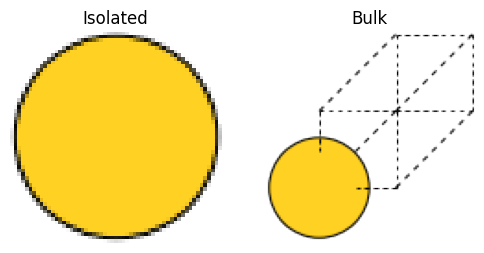

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fig, axes = plt.subplots(1, 2, figsize=(6, 3))
ax0, ax1 = axes
ax0.imshow(mpimg.imread("output/au_iso.png"))
ax0.set_axis_off()
ax0.set_title("Isolated")
ax1.imshow(mpimg.imread("output/au_bulk.png"))
ax1.set_axis_off()
ax1.set_title("Bulk")
fig.show()

In [9]:
from pfcc_extras.visualize.view import view_ngl

view_ngl([au_iso, au_bulk], replace_structure=True)

上記の計算を様々な元素に対して実行してみます。

In [10]:
def calc_cohesive_energy(symbol, calculator):
    atoms_iso = Atoms(symbol)
    atoms_bulk = bulk(symbol)

    atoms_iso.calc = calculator
    E_iso = atoms_iso.get_total_energy() / len(atoms_iso)

    atoms_bulk.calc = calculator
    atoms_bulk_strain = StrainFilter(atoms_bulk)
    opt = LBFGS(atoms_bulk_strain, logfile=None)
    opt.run()
    E_bulk = atoms_bulk.get_total_energy() / len(atoms_bulk)
    E_coh = E_bulk - E_iso
    print(f"{symbol}: E_bulk {E_bulk:.2f} - E_iso {E_iso:.2f} = E_coh {E_coh:.2f} eV/atom")
    return E_bulk, E_iso, E_coh

In [11]:
for symbol in ["Fe", "Co", "Ni", "Cu", "Pt", "Au"]:
    calc_cohesive_energy(symbol, calculator)

Fe: E_bulk -5.00 - E_iso -0.03 = E_coh -4.97 eV/atom
Co: E_bulk -5.13 - E_iso 0.00 = E_coh -5.14 eV/atom
Ni: E_bulk -4.82 - E_iso 0.00 = E_coh -4.82 eV/atom
Cu: E_bulk -3.51 - E_iso 0.00 = E_coh -3.51 eV/atom
Pt: E_bulk -5.45 - E_iso -0.02 = E_coh -5.43 eV/atom
Au: E_bulk -3.03 - E_iso -0.04 = E_coh -2.99 eV/atom


文献 "[Bulk Properties of Transition Metals: A Challenge for the Design of Universal Density Functionals](https://pubs.acs.org/doi/10.1021/ct500532v)" のTable 2. に各元素における凝集エネルギーのDFT計算値や実験値が収録されています。

PFP CRYSTAL_U0 modeの計算条件であるPBE/GGAと比べてみてみると、近い値になっていることがわかります。

凝集エネルギーは単元素だけではなく、複数元素からなる系でも定義されます。

例として、GaAsの凝集エネルギーを求めてみましょう。以下の文献を見ると、実験値としては6.5~6.7 eV/GaAs 程度となるようです。

 - Cohesive Energies: http://cmt.dur.ac.uk/sjc/thesis_ppr/node50.html
 - GaAs (zinc-blende)
http://www.ciss.iis.u-tokyo.ac.jp/theme/multi/material/periodic_detail/examples/GaAs_zb_gga/GaAs_zb_ggapbe.html


> Data retrieved from the Materials Project for GaAs (mp-2534) from database version v2021.11.10. <br/>
> https://next-gen.materialsproject.org/materials/mp-2534

In [12]:
from ase.io import read

atoms_bulk = read("../input/mp_2534-GaAs.cif")
view_ngl(atoms_bulk, representations=["ball+stick"])

まず上記結晶としてのGaAsのエネルギーは以下のように計算されます。<br/>
ここではCellの大きさと原子の座標両方を最適化するため、`ExpCellFilter`を使用しています。

In [13]:
atoms_bulk.calc = calculator
atoms_bulk_strain = ExpCellFilter(atoms_bulk)
opt = LBFGS(atoms_bulk_strain)
opt.run()
E_bulk = atoms_bulk.get_total_energy()

print(f"E_bulk {E_bulk:.3f} eV")

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:39:07      -25.179115*       0.2399
LBFGS:    1 06:39:08      -25.177728*       0.5148
LBFGS:    2 06:39:08      -25.179506*       0.0026
E_bulk -25.180 eV


次に孤立系のエネルギーはGa とAsを別々に求める必要あります。

In [14]:
atoms_ga = Atoms("Ga")
atoms_ga.calc = calculator
E_ga = atoms_ga.get_total_energy()
atoms_as = Atoms("As")
atoms_as.calc = calculator
E_as = atoms_as.get_total_energy()

print(f"E_ga {E_ga:.2f} eV, E_as {E_as:.2f} eV")

E_ga -0.03 eV, E_as 0.00 eV


In [15]:
E_iso = E_ga + E_as
E_coh = E_bulk / len(atoms_bulk) * 2.0 - E_iso
print(f"E_coh {E_coh:.2f} eV/atom")

E_coh -6.27 eV/atom


GaAs 1ペアあたりの凝集エネルギーを計算するために、E_solidは2原子分の値を計算し、E_isoはGaとAsのエネルギーを足しています。<br/>
上記得られた値を実験値と比較してみると、5%程度の誤差で得られているようです。

## 空孔生成エネルギー - Vacancy formation energy

結晶に欠陥がある系のエネルギーとして、空孔生成エネルギーは以下のように定義されます。

$$E_{\rm{V}} = E_{\rm{defect}} - E_{\rm{bulk}} \cdot N_{\rm{defect}} / N_{\rm{bulk}}$$

ここで、欠陥がある系の原子数を$N_{\rm{defect}}$, エネルギーを$E_{\rm{defect}}$、結晶系の原子数を$N_{\rm{bulk}}$, エネルギーを$E_{\rm{bulk}}$としています。


実例で、Al結晶における空孔生成エネルギーを計算してみましょう。

原子空孔がある系を作る際は、理想的には無限につづく結晶から原子を１つ取り除くのですが、実際には無限に大きい結晶は計算できないので十分に大きいサイズの結晶を作り、そこから原子を抜く形で欠陥構造を生成します。

以下では `size=(5, 5, 5)` のように、Unit cellを繰り返して大きくした **スーパーセル** を作成し、そこから原子を１つ取り除くことで欠陥構造を作成しています。<br/>
欠陥構造は、とても大きな結晶に対して、ごく一部のみで欠陥が発生している場合を想定する(欠陥が疎な構造)ため、
スーパーセルのサイズは大きくしたほうがより適切なモデリングとなりますが、一方で大きくしすぎると計算時間がかかってしまうため、適切な大きさを選択する必要があります。

欠陥構造作成後は、欠陥の影響によりエネルギーが極小になる構造は結晶配置からは少し変わると考えられるため、再度構造最適化を行います。<br/>
ただし、結晶に対して欠陥が1つある程度では格子定数は変わらないと考えられるため、欠陥構造を作成する際は構造最適化された結晶構造の格子定数から変わらないようにします。

In [16]:
symbol = "Al"
size = (5, 5, 5)

atoms_bulk = bulk(symbol) * size

atoms_bulk.calc = calculator
atoms_bulk_strain = ExpCellFilter(atoms_bulk)
opt = LBFGS(atoms_bulk_strain)
opt.run()
E_bulk = atoms_bulk.get_total_energy()

atoms_defect = atoms_bulk.copy()
# Create defect by removing 0-th atom
del atoms_defect[0]

atoms_defect.calc = calculator
opt = LBFGS(atoms_defect)
opt.run()
E_defect = atoms_defect.get_total_energy()
E_v = E_defect - E_bulk * len(atoms_defect) / len(atoms_bulk)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:39:12     -427.703430*       2.9095
LBFGS:    1 06:39:12     -419.901030*     140.5879
LBFGS:    2 06:39:12     -427.708198*       0.8449
LBFGS:    3 06:39:12     -427.708645*       0.2433
LBFGS:    4 06:39:12     -427.708658*       0.0093
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 06:39:12     -423.542281*       0.2084
LBFGS:    1 06:39:12     -423.549872*       0.1953
LBFGS:    2 06:39:12     -423.603128*       0.0452


結果として、以下のように空孔生成エネルギーが得られます。

In [17]:
E_v = E_defect - E_bulk * len(atoms_defect) / len(atoms_bulk)
print(f"E_bulk  : {E_bulk:.2f} eV")
print(f"E_defect: {E_defect:.2f} eV")
print(f"E_v     : {E_v:.2f} eV")

E_bulk  : -427.71 eV
E_defect: -423.60 eV
E_v     : 0.68 eV


In [18]:
view_ngl([atoms_defect, atoms_bulk], replace_structure=True)

この計算を様々な元素、スーパーセルサイズで行えるようにしてみましょう。

In [19]:
def calc_vacancy_energy(symbol: str, calculator, size=(5, 5, 5)):

    atoms_bulk = bulk(symbol) * size

    atoms_bulk.calc = calculator
    atoms_bulk_strain = ExpCellFilter(atoms_bulk)
    opt = LBFGS(atoms_bulk_strain, logfile=None)
    opt.run()
    E_bulk = atoms_bulk.get_total_energy()

    atoms_defect = atoms_bulk.copy()
    # Create defect by removing 0-th atom
    del atoms_defect[0]

    atoms_defect.calc = calculator
    opt = LBFGS(atoms_defect, logfile=None)
    opt.run()
    E_defect = atoms_defect.get_total_energy()
    E_v = E_defect - E_bulk * len(atoms_defect) / len(atoms_bulk)
    return E_bulk, E_defect, E_v

In [20]:
for symbol in ["Al", "Cu", "Mo", "Ta", "Si"]:
    E_bulk, E_defect, E_v = calc_vacancy_energy(symbol=symbol, calculator=calculator)
    print(f"{symbol} E_v = {E_v:.2f} eV")

Al E_v = 0.68 eV
Cu E_v = 1.10 eV
Mo E_v = 3.47 eV
Ta E_v = 3.12 eV
Si E_v = 3.20 eV


参考文献

 - Vacancy Formation Energy: http://micro.stanford.edu/mediawiki/images/2/29/VFE.pdf

こちらには、古典力場で計算した空孔形成エネルギーが掲載されています。Potentialが異なるため、比較はできませんが、参考程度に見比べてみると概ね似た傾向となっていることがわかります。

最後に、理解を深めるために、スーパーセルのサイズ依存性を調べてみましょう。

In [21]:
symbol = "Al"
E_v_list = []
for i in range(2, 8):
    E_bulk, E_defect, E_v = calc_vacancy_energy(symbol=symbol, calculator=calculator, size=(i, i, i))
    print(f"{symbol} i = {i}, E_v = {E_v:.2f} eV")
    E_v_list.append(E_v)

Al i = 2, E_v = 0.76 eV
Al i = 3, E_v = 0.69 eV
Al i = 4, E_v = 0.72 eV
Al i = 5, E_v = 0.68 eV
Al i = 6, E_v = 0.67 eV
Al i = 7, E_v = 0.68 eV


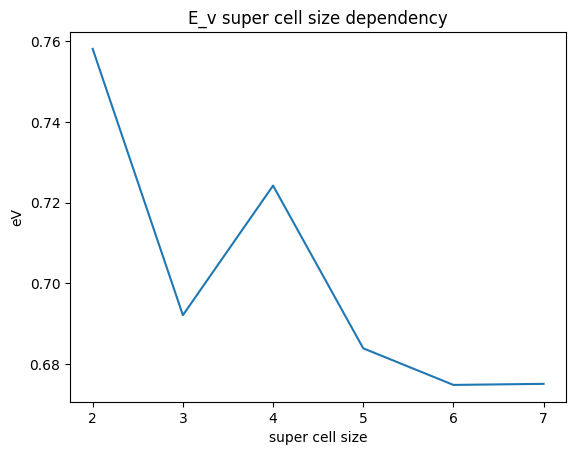

In [22]:
plt.plot(range(2, 8), E_v_list)
plt.title("E_v super cell size dependency")
plt.ylabel("eV")
plt.xlabel("super cell size")
plt.show()

スーパーセルサイズが大きくなってくると正しい値に収束していきますが、スーパーセルサイズが小さすぎると間違った値が得られることがわかります。